# 데이터 불러오기

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_2.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 30:
        row_5h = group.iloc[29]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

(91, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,CN,CNNGB,060db0be-c97f-3f11-8304-c637fe4fa4d5,2024-10-01 15:40:00,239.30,240.0,34.515247,128.546545,CNNGB,2,0
1,CN,CNSHA,06724e0f-5a08-3aa8-b42c-97acf4f8102d,2024-10-26 23:40:00,227.50,230.0,34.058808,128.528450,CNSHA,2,2
2,CN,CNSHA,06e20c85-1dab-34e7-bbdb-6ed30bd68672,2024-11-09 16:20:00,202.80,205.0,34.239492,128.754670,CNSHA,2,2
3,CN,CNSHA,0986a961-7abf-3ade-9b02-40c5323168aa,2024-07-21 14:00:00,224.30,223.0,34.363648,128.308899,CNSHA,2,2
4,CN,CNSHA,0f09bfcc-ce6f-3096-a547-5618e8e76d29,2024-11-03 19:00:00,239.15,238.5,34.251924,128.100558,CNSHA,2,2


PORT_NAME
CNSHA    72
CNNGB    11
CNTAC     4
CNNJI     4
Name: count, dtype: int64

In [35]:
df_5h.to_csv('./dataset/df_5h_extracted.csv', index=False)

## LightGBM

In [4]:
# ===== 1. 라이브러리 import =====
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier


# ===== 3. 특성과 라벨 설정 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]

# ===== 4. 라벨 인코딩 =====
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 5. 학습/테스트 데이터 분할 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# ===== 6. LightGBM 모델 정의 및 학습 =====
lgb_model = LGBMClassifier(
    is_unbalance=True,   # 클래스 불균형 자동 보정
    n_estimators=50,     # 트리 개수 줄이기
    n_jobs=-1,           # 병렬 처리
    random_state=42
)
lgb_model.fit(X_train, y_train)

# ===== 7. 예측 및 성능 평가 =====
y_pred = lgb_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 4
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -3.044522
[LightGBM] [Info] Start training from score -0.231112
[LightGBM] [Info] Start training from score -3.044522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 소수데이터에 가중치 + XGBoost

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]

# ===== 4. 라벨 인코딩 =====
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 5. 학습/테스트 분할 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 6. 클래스별 가중치 계산 =====
class_counts = np.bincount(y_train)
total = sum(class_counts)
class_weights = {i: total / c for i, c in enumerate(class_counts)}
sample_weights = np.array([class_weights[label] for label in y_train])

# ===== 7. XGBoost 모델 학습 =====
xgb_model = XGBClassifier(
    n_estimators=50,            # 트리 개수
    max_depth=5,                # 트리 깊이 제한
    n_jobs=-1,                  # 병렬 처리
    use_label_encoder=False,    # 경고 제거
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# ===== 8. 예측 및 성능 평가 =====
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       CNNGB       0.33      0.50      0.40         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.81      0.87      0.84        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.74        19
   macro avg       0.29      0.34      0.31        19
weighted avg       0.68      0.74      0.70        19



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Soft Voting - RandomForest, XGBoost 사용

In [19]:
# 기본 라이브러리
import pandas as pd
import numpy as np

# 전처리 및 분할
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 분류 모델들
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# 평가 지표
from sklearn.metrics import classification_report


# 개별 모델 재정의 (최적 파라미터 기반)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train, sample_weight=sample_weights)

# 예측 및 평가
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       CNNGB       0.33      0.50      0.40         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.81      0.87      0.84        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.74        19
   macro avg       0.29      0.34      0.31        19
weighted avg       0.68      0.74      0.70        19



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ✅ Oversampling + XGBoost + RandomForest


📦 [데이터 개수]
Train: 230개
Test : 58개
전체 : 288개


C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       CNNGB       1.00      1.00      1.00        15
       CNNJI       1.00      1.00      1.00        14
       CNSHA       1.00      0.93      0.97        15
       CNTAC       0.93      1.00      0.97        14

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\anaconda3\Lib\site-packages\xgbo

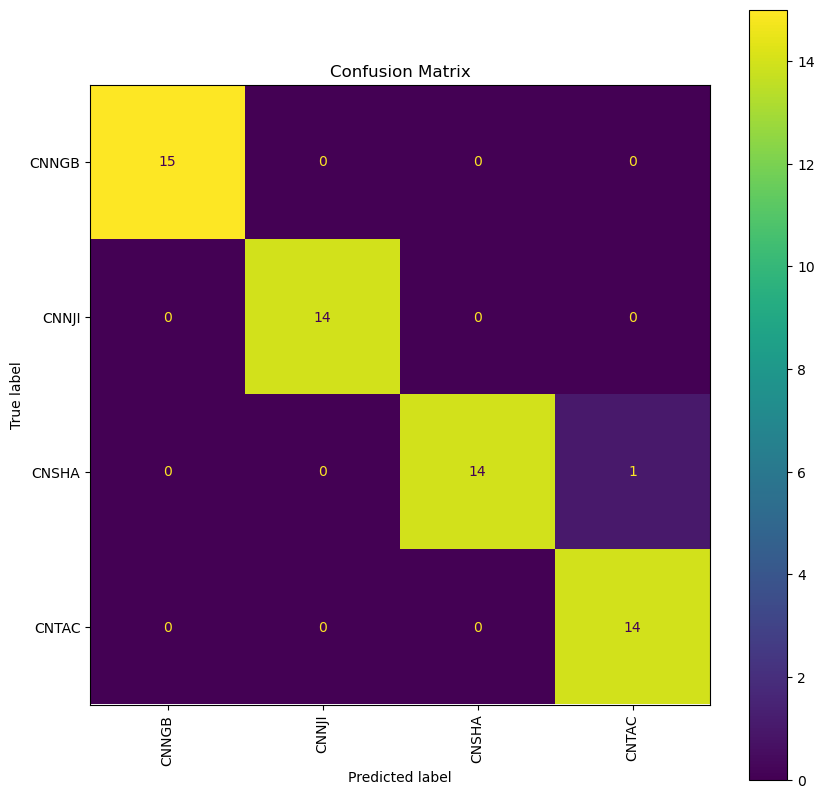

📊 [교차검증 결과]
Accuracy (Train): 0.9957
Accuracy (Test): 0.9828
CV Accuracy Mean: 0.9391 ± 0.0590
CV F1 Macro: 0.9328
CV Precision Macro: 0.9461
✅ 과적합 위험 없음

📄 [Classification Report]
              precision    recall  f1-score   support

       CNNGB       1.00      1.00      1.00        15
       CNNJI       1.00      1.00      1.00        14
       CNSHA       1.00      0.93      0.97        15
       CNTAC       0.93      1.00      0.97        14

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58


📊 [교차검증 및 과적합 점검 결과]
학습 정확도              : 0.9957
테스트 정확도            : 0.9828
정확도 차이              : 0.0129 과적합 위험 없음
교차검증 평균 정확도     : 0.9391 ± 0.0590
교차검증 F1 매크로 평균  : 0.9328
교차검증 정밀도 평균     : 0.9461


In [9]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils import resample

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded

# ===== 4. 오버샘플링 적용 =====
max_count = df_5h["label"].value_counts().max()
resampled = []

for label in df_5h["label"].unique():
    subset = df_5h[df_5h["label"] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    resampled.append(upsampled)

df_balanced = pd.concat(resampled)

# ===== 5. 학습/테스트 분리 =====
X_bal = df_balanced[features]
y_bal = df_balanced["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

np.save("datasets/X_train_cluster2.npy", X_train)
np.save("datasets/X_test_cluster2.npy", X_test)
np.save("datasets/y_train_cluster2.npy", y_train)
np.save("datasets/y_test_cluster2.npy", y_test)

# ===== 0. 데이터 수 출력 =====
print("\n📦 [데이터 개수]")
print(f"Train: {len(X_train)}개")
print(f"Test : {len(X_test)}개")
print(f"전체 : {len(X_train) + len(X_test)}개")

# ===== 6. 모델 정의 및 학습 (하이퍼파라미터 조정 포함) =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=7,                 # 깊이 제한
    min_samples_leaf=3,          # 최소 샘플 수 제한
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=4,                 # 깊이 제한 (기존 5 → 4)
    learning_rate=0.05,          # 학습률 낮춤
    reg_alpha=0.1,               # L1 규제
    reg_lambda=1.0,              # L2 규제
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

# ===== 7. 평가 =====
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== 1. 교차검증 정확도 =====
acc_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='precision_macro')

# ===== 2. 학습/테스트 정확도 =====
train_score = voting_clf.score(X_train, y_train)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 3. 예측 및 리포트 =====
y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 4. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 5. 결과 출력 =====
print("📊 [교차검증 결과]")
print(f"Accuracy (Train): {train_score:.4f}")
print(f"Accuracy (Test): {test_score:.4f}")
print(f"CV Accuracy Mean: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV F1 Macro: {f1_scores.mean():.4f}")
print(f"CV Precision Macro: {prec_scores.mean():.4f}")
if gap > 0.1:
    print(f"⚠️ 과적합 의심: 학습/테스트 정확도 차이 {gap:.4f}")
else:
    print("✅ 과적합 위험 없음")

print("\n📄 [Classification Report]")
print(report)

# ===== 5. 결과 출력 =====
print("\n📊 [교차검증 및 과적합 점검 결과]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '과적합 위험 없음'}")
print(f"교차검증 평균 정확도     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"교차검증 F1 매크로 평균  : {f1_scores.mean():.4f}")
print(f"교차검증 정밀도 평균     : {prec_scores.mean():.4f}")

In [10]:
# 오버샘플링된 레이블 → 항구명으로 다시 복원
df_balanced["PORT_NAME"] = le.inverse_transform(df_balanced["label"])

# 항구별 데이터 개수 출력
print("\n🛳️ [오버샘플링된 항구별 샘플 개수]")
print(df_balanced["PORT_NAME"].value_counts())


🛳️ [오버샘플링된 항구별 샘플 개수]
PORT_NAME
CNNGB    72
CNSHA    72
CNTAC    72
CNNJI    72
Name: count, dtype: int64


### 복잡도 확인

In [71]:
import numpy as np

# ===== [1] RandomForest 복잡도 분석 =====
rf_model = voting_clf.named_estimators_["rf"]
tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]

print("\n🌲 RandomForest 복잡도 정보")
print(f"- 트리 개수         : {len(tree_depths)}")
print(f"- 평균 깊이         : {np.mean(tree_depths):.2f}")
print(f"- 최대 깊이         : {np.max(tree_depths)}")
print(f"- 최소 깊이         : {np.min(tree_depths)}")

# ===== [2] XGBoost 복잡도 분석 =====
xgb_model = voting_clf.named_estimators_["xgb"]
booster = xgb_model.get_booster()
trees = booster.get_dump()

print("\n🔥 XGBoost 복잡도 정보")
print(f"- 트리 개수         : {len(trees)}")
print(f"- 설정된 max_depth  : {xgb.max_depth}")

# ===== [3] VotingClassifier 구성 확인 =====
print("\n🧠 VotingClassifier 구성 모델:")
for name, model in voting_clf.named_estimators_.items():
    print(f"- {name}: {type(model).__name__}")

# ===== [4] Accuracy Gap (= 복잡도 간접 지표) =====
gap = train_score - test_score
print(f"\n📉 Accuracy Gap (과적합 지표): {gap:.4f}")
if gap > 0.1:
    print("⚠️ 과적합 위험 → 복잡도 높음")
else:
    print("✅ 과적합 위험 없음 → 복잡도 적절")



🌲 RandomForest 복잡도 정보
- 트리 개수         : 100
- 평균 깊이         : 6.95
- 최대 깊이         : 7
- 최소 깊이         : 6

🔥 XGBoost 복잡도 정보
- 트리 개수         : 200
- 설정된 max_depth  : 4

🧠 VotingClassifier 구성 모델:
- rf: RandomForestClassifier
- xgb: XGBClassifier

📉 Accuracy Gap (과적합 지표): 0.0129
✅ 과적합 위험 없음 → 복잡도 적절


In [59]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_model_2.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_2.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


### test 데이터 내부에서도 일반화 성능의 안정성

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = []
f1_scores = []

for train_idx, val_idx in skf.split(X_test, y_test):
    X_val = X_test.iloc[val_idx]
    y_val = y_test.iloc[val_idx]
    y_val_pred = voting_clf.predict(X_val)
    
    acc_scores.append(accuracy_score(y_val, y_val_pred))
    f1_scores.append(f1_score(y_val, y_val_pred, average='macro'))

print(f"📊 [Test Set Cross-Validation]")
print(f"Test Accuracy Mean: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Test F1 Macro     : {np.mean(f1_scores):.4f}")


📊 [Test Set Cross-Validation]
Test Accuracy Mean: 0.9833 ± 0.0333
Test F1 Macro     : 0.9829


### TEST SET 과적합 확인

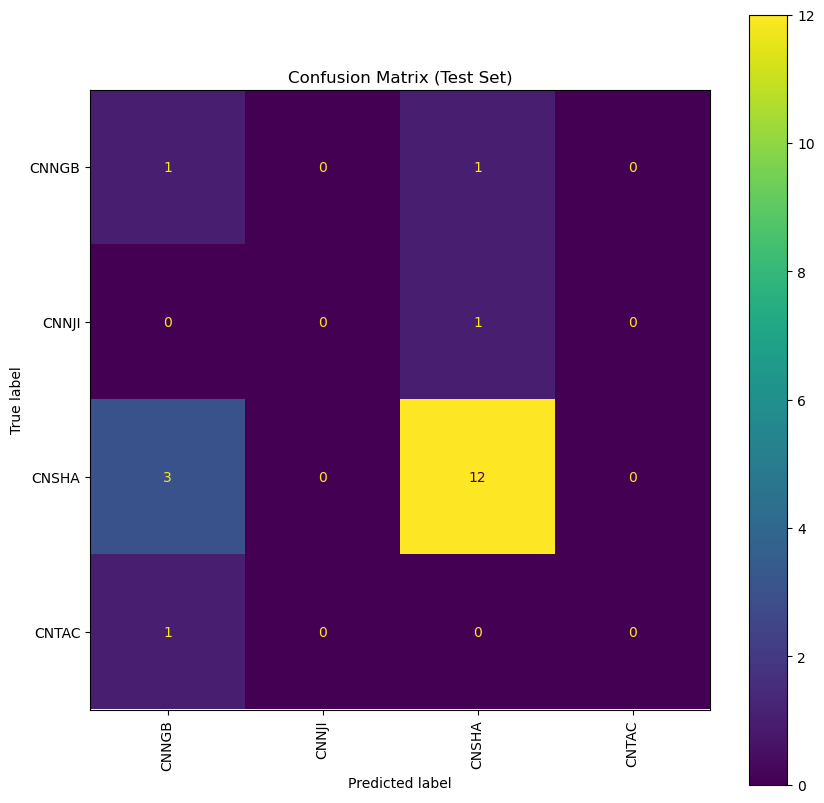

📊 [학습/테스트 정확도 및 교차검증 결과]
Train Accuracy       : 1.0000
Test Accuracy        : 0.6842
→ Accuracy Gap       : 0.3158 ⚠️ 과적합 의심

CV Accuracy Mean     : 0.9650 ± 0.0326
CV F1 Macro          : 0.9644
CV Precision Macro   : 0.9701

📄 [Test Set Classification Report]
              precision    recall  f1-score   support

       CNNGB       0.20      0.50      0.29         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.86      0.80      0.83        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.68        19
   macro avg       0.26      0.33      0.28        19
weighted avg       0.70      0.68      0.68        19



In [8]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt

# ===== 2. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded

# ===== 3. 학습/테스트 분리 (먼저 분리하고 나서 오버샘플링은 훈련셋에만) =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 4. 오버샘플링 (훈련 데이터에만 적용) =====
df_train = pd.DataFrame(X_train, columns=features)
df_train["label"] = y_train

max_count = df_train["label"].value_counts().max()
resampled = []

for label in df_train["label"].unique():
    subset = df_train[df_train["label"] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    resampled.append(upsampled)

df_balanced = pd.concat(resampled)
X_train_bal = df_balanced[features]
y_train_bal = df_balanced["label"]

# ===== 5. 모델 정의 =====
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# ===== 6. 모델 학습 =====
voting_clf.fit(X_train_bal, y_train_bal)

# ===== 7. 교차검증 (훈련셋 기준) =====
acc_scores = cross_val_score(voting_clf, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train_bal, y_train_bal, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train_bal, y_train_bal, cv=5, scoring='precision_macro')

# ===== 8. 성능 측정 =====
train_score = voting_clf.score(X_train_bal, y_train_bal)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 9. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

# ===== 10. 결과 출력 =====
print("📊 [학습/테스트 정확도 및 교차검증 결과]")
print(f"Train Accuracy       : {train_score:.4f}")
print(f"Test Accuracy        : {test_score:.4f}")
print(f"→ Accuracy Gap       : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 안정적'}")

print(f"\nCV Accuracy Mean     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV F1 Macro          : {f1_scores.mean():.4f}")
print(f"CV Precision Macro   : {prec_scores.mean():.4f}")

print("\n📄 [Test Set Classification Report]")
print(report)


## 오버샘플링 + Soft Voting + class_weight (훈련셋에만 적용)

🔍 훈련 데이터: 81개
🔍 테스트 데이터: 10개


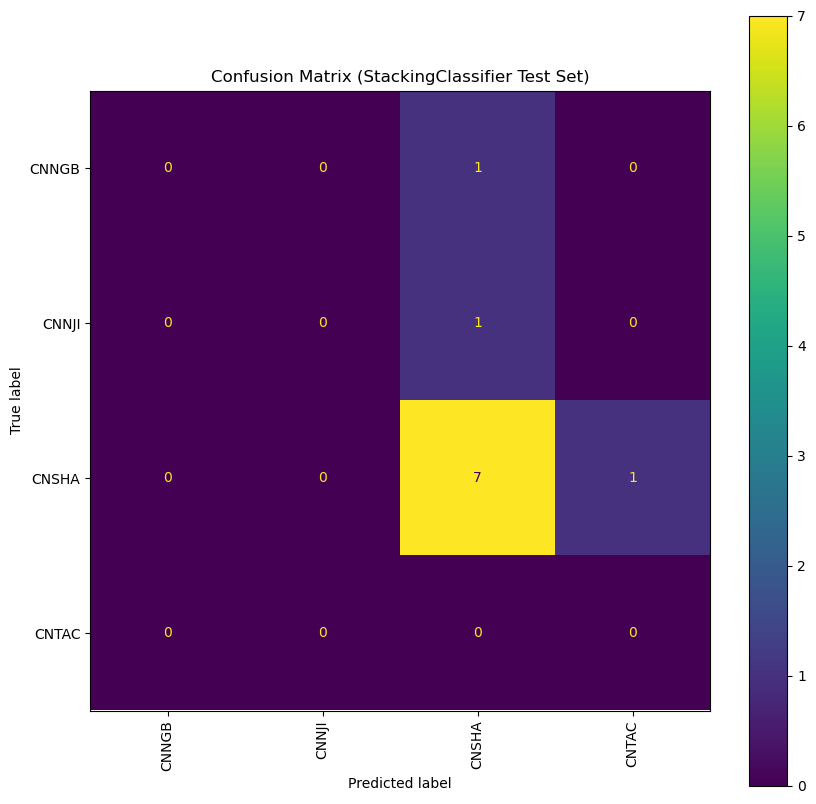


📊 [StackingClassifier 성능 요약]
Train Accuracy       : 0.9727
Test Accuracy        : 0.7000
→ Accuracy Gap       : 0.2727 ⚠️ 과적합 의심

CV Accuracy Mean     : 0.8203 ± 0.0673
CV F1 Macro          : 0.8147
CV Precision Macro   : 0.8277

📄 [Test Set Classification Report]
              precision    recall  f1-score   support

       CNNGB       0.00      0.00      0.00         1
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.78      0.88      0.82         8
       CNTAC       0.00      0.00      0.00         0

    accuracy                           0.70        10
   macro avg       0.19      0.22      0.21        10
weighted avg       0.62      0.70      0.66        10



In [33]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# ===== 2. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_5h["label"] = y_encoded

# ===== 3. train/test 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42
)
print(f"🔍 훈련 데이터: {X_train.shape[0]}개")
print(f"🔍 테스트 데이터: {X_test.shape[0]}개")

# ===== 4. SMOTE 오버샘플링 =====
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ===== 5. 개별 모델 정의 =====
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1,
    random_state=42
)

# ===== 6. StackingClassifier 정의 =====
base_estimators = [
    ('rf', rf),
    ('xgb', xgb)
]

final_model = RandomForestClassifier(n_estimators=100, random_state=42)
stack_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_model, passthrough=True)

# ===== 7. 학습 =====
stack_clf.fit(X_train_bal, y_train_bal)

# ===== 8. 교차검증 =====
acc_scores = cross_val_score(stack_clf, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
f1_scores = cross_val_score(stack_clf, X_train_bal, y_train_bal, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(stack_clf, X_train_bal, y_train_bal, cv=5, scoring='precision_macro')

# ===== 9. 과적합 여부 확인 =====
train_score = stack_clf.score(X_train_bal, y_train_bal)
test_score = stack_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 10. 예측 결과 분석 =====
y_pred = stack_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 11. Confusion Matrix 시각화 =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix (StackingClassifier Test Set)")
plt.grid(False)
plt.show()

# ===== 12. 결과 출력 =====
print("\n📊 [StackingClassifier 성능 요약]")
print(f"Train Accuracy       : {train_score:.4f}")
print(f"Test Accuracy        : {test_score:.4f}")
print(f"→ Accuracy Gap       : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 안정적'}")
print(f"\nCV Accuracy Mean     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV F1 Macro          : {f1_scores.mean():.4f}")
print(f"CV Precision Macro   : {prec_scores.mean():.4f}")

print("\n📄 [Test Set Classification Report]")
print(report)


In [48]:
import joblib
import os

# Voting Classifier 저장
joblib.dump(voting_clf, "model/port_model_2.joblib")

# LabelEncoder 저장
joblib.dump(le, "model/encoder_2.joblib")

print("✅ 모델과 인코더 저장 완료!")

✅ 모델과 인코더 저장 완료!


## Train/Test 분리 후 오버샘플링을 적용한 Soft Voting

In [23]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils import resample

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 4. 훈련/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 5. 오버샘플링 (훈련 데이터에만 적용) =====
train_df = pd.DataFrame(X_train, columns=features)
train_df["label"] = y_train

max_count = train_df["label"].value_counts().max()
resampled = []
for label in train_df["label"].unique():
    subset = train_df[train_df["label"] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    resampled.append(upsampled)

train_balanced = pd.concat(resampled)
X_train_bal = train_balanced[features]
y_train_bal = train_balanced["label"]

# ===== 6. 모델 정의 =====
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False,
                    eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

# ===== 7. 학습 및 평가 =====
voting_clf.fit(X_train_bal, y_train_bal)
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:38:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       CNNGB       0.20      0.50      0.29         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.86      0.80      0.83        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.68        19
   macro avg       0.26      0.33      0.28        19
weighted avg       0.70      0.68      0.68        19



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
!pip install imbalanced-learn

## SMOTE 오버샘플링 + Soft voting

In [34]:
# ===== 1. 라이브러리 =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # 🔥 핵심
import warnings
warnings.filterwarnings("ignore")

# ===== 3. 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features]
y = df_5h["PORT_NAME"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 4. 훈련/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 5. SMOTE 오버샘플링 적용 (훈련셋에만) =====
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ===== 6. 모델 정의 =====
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False,
                    eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

# ===== 7. 학습 및 평가 =====
voting_clf.fit(X_train_smote, y_train_smote)
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       CNNGB       0.25      0.50      0.33         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.87      0.87      0.87        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.74        19
   macro avg       0.28      0.34      0.30        19
weighted avg       0.71      0.74      0.72        19



# LSTM